In [118]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats as st

Stopping because outliers are not symmetrical
Outliers ground truth: 182, outliers found: 7
Precision: 100.0, recall: 3.8


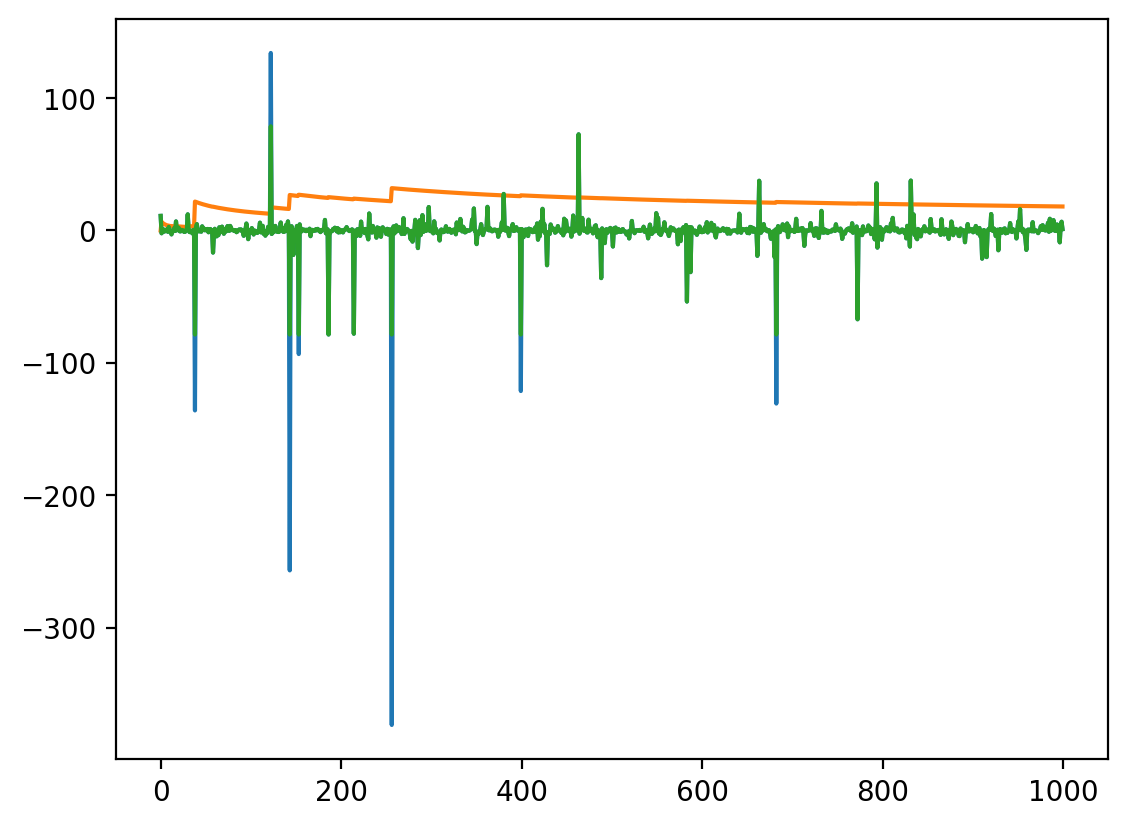

In [602]:
def generate(N, rva, rvb, rv_outlier, p_outliers=0.01):
    rv_outlier_happens = st.bernoulli(p_outliers)
    
    base = rva.rvs(N)
    candidate = rvb.rvs(N)
    
    outliers_base = rv_outlier_happens.rvs(N) * rv_outlier.rvs(N)
    outliers_candidate = rv_outlier_happens.rvs(N) * rv_outlier.rvs(N)
    
    return (base + outliers_base) - (candidate + outliers_candidate), outliers_base + outliers_candidate

N = 1000
y, outliers = generate(N, st.lognorm(1), st.lognorm(1), st.lognorm(3), 0.1)

cum_var = [np.var(y[:i+1]) for i in np.arange(0, N)]
x = np.arange(0, N)

threshold = filter_symmetrical_outliers(y)

plt.plot(x, y)
plt.plot(x, np.sqrt(cum_var))
plt.plot(np.clip(y, -threshold, threshold))

N_outliers = len(outliers[outliers != 0])
outliers_marked = len(y[(np.abs(y) > threshold)])
if N_outliers > 0 and outliers_marked:
    recall = len(y[(np.abs(y) > threshold) & (outliers != 0)]) / N_outliers
    precision = len(y[(np.abs(y) > threshold) & (outliers != 0)]) / outliers_marked
    
    print(f"Outliers ground truth: {len(outliers[outliers != 0])}, outliers found: {outliers_marked}")
    print(f"Precision: {precision * 100:.1f}, recall: {recall * 100:.1f}")
else:
    print("No outliers were found")

In [588]:
def filter_symmetrical_outliers(data):
    def inner_pass(data, counts):
        """
        counts - (a, b) tuple of two counters with the number of registered outliers on
                 baseline and canidate
        """
        base_count, candidate_count = counts
        if len(data) < 2:
            print("Stopping because there is no more samples")
            return;

        #print(y)
        #print(data[0], data[-1])
        var = np.var(data)
        reduced_data, base_count, candidate_count = (data[1:], base_count + 1, candidate_count) if abs(data[0]) > abs(data[-1]) \
            else (data[:-1], base_count, candidate_count + 1)
        reduced_var = np.var(reduced_data)

        # Check if ignoring the outlier will reduce variance
        if (var / reduced_var) < 1.1:
            print("Stopping because variance stop shrinking")
            return
        #print(f"Var reduction is: {var / reduced_var:5.2}", )
        
        # Check if distribution of outliers is random enough
        rv = st.binom(base_count + candidate_count, 0.5)
        i_min, i_max = rv.interval(0.90);
        
        #print(f"Counts: {base_count} {candidate_count}")
        #print(f"Interval: {i_min} - {i_max}")

        if min(base_count, candidate_count) < i_min:
            print("Stopping because outliers are not symmetrical")
            return
        
        proposed_threshold = inner_pass(reduced_data, (base_count, candidate_count))
        return proposed_threshold if proposed_threshold else max(abs(data[1]), abs(data[-2]))

    data = data.copy()
    data.sort()
    return inner_pass(data, (0, 0))

print(filter_symmetrical_outliers(y))

Stopping because variance stop shrinking
25.162329843684805


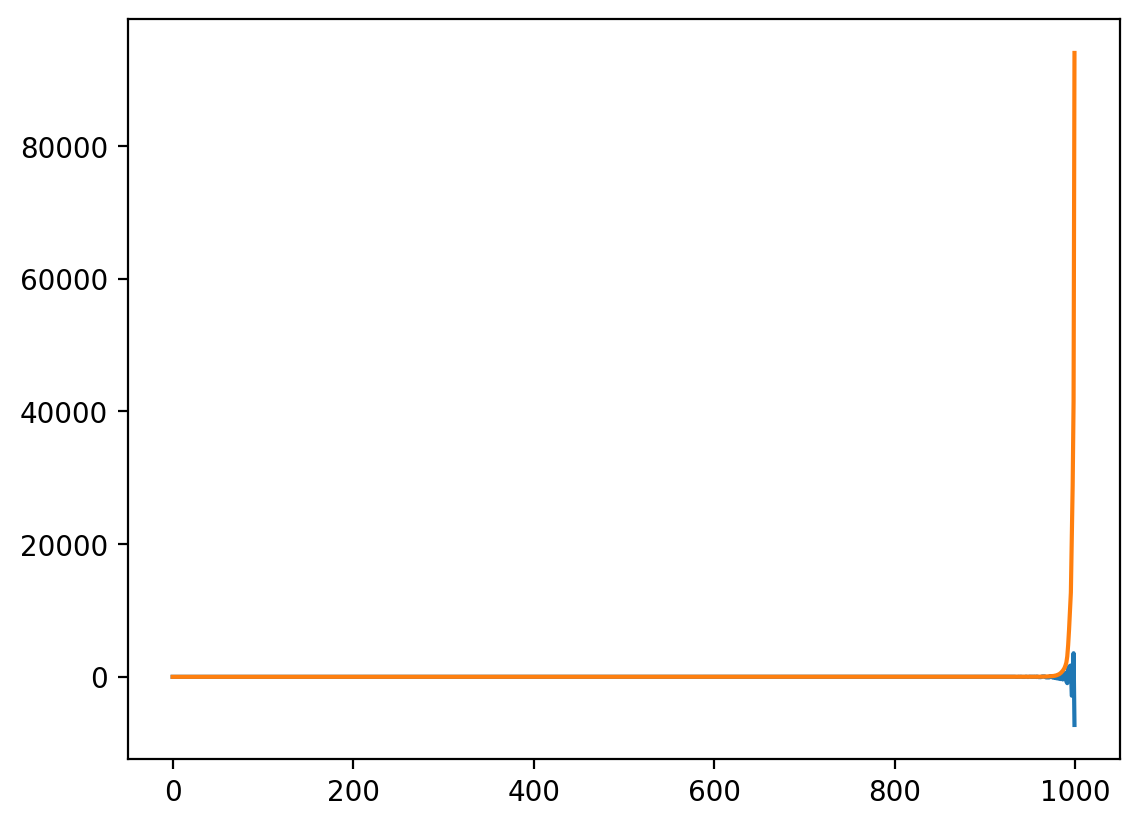

In [509]:
def plot_cumulative_var(input):
    input = input[np.abs(y).argsort()]
    cum_var = [np.var(input[:i+1]) for i in np.arange(0, N)]
    x = np.arange(0, N)
    plt.plot(x, input)
    plt.plot(x, cum_var)

plot_cumulative_var(y)

(3.0, 7.0)


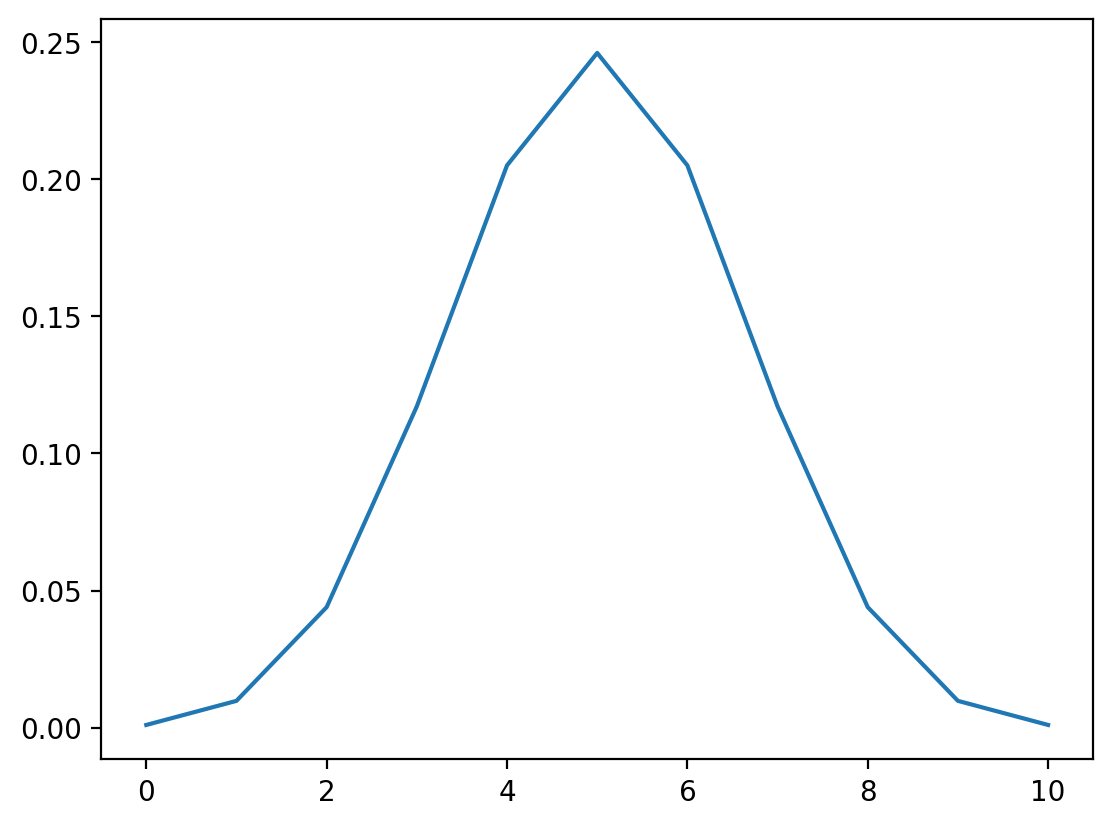

In [230]:
N = 10
_r = st.binom(N, 0.5)
x = np.arange(0, N + 1)
plt.plot(x, _r.pmf(x))
print(_r.interval(0.8))